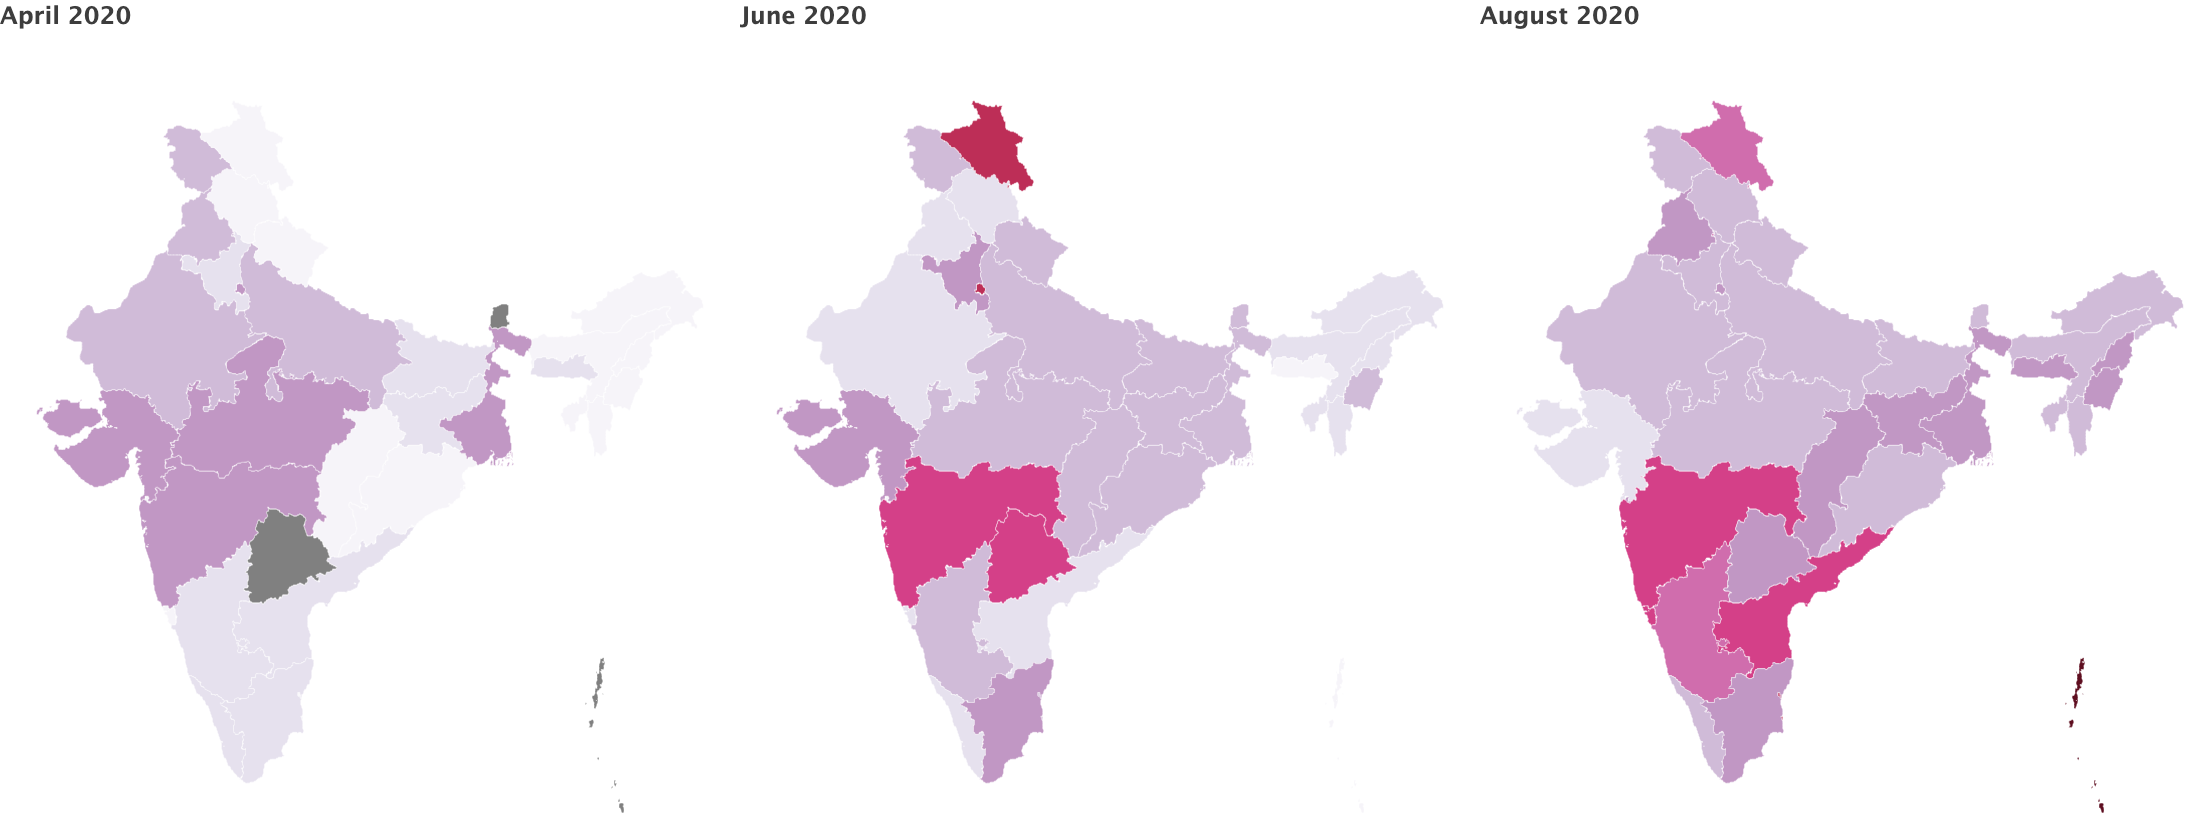

In [ ]:
pip install lets_plot -U

In [ ]:
import pandas as pd
import geopandas as gpd
import numpy as np


from lets_plot import *
LetsPlot.setup_html()

import lets_plot
lets_plot.__version__

## Data: India statewise COVID-19 testing details 

In [ ]:
dat = pd.read_csv("/kaggle/input/covid19-in-india/StatewiseTestingDetails.csv")
dat.head()

In [ ]:
dat.Date = pd.to_datetime(dat.Date)
dat = dat[["Date","State","TotalSamples","Positive"]].dropna()

### Cumulative number of total samples tested till the given date (by State)

In [ ]:
(ggplot(dat) 
 + geom_line(aes(x="Date", y="TotalSamples", color="State"),
             size=1.5,
             show_legend=False,
             tooltips=layer_tooltips(["State", "TotalSamples"])
                         .format("TotalSamples", ".1s")) 
 + scale_x_datetime(name="", format="%b\'%y") 
 + ggsize(785, 350)
)

### Cumulative number of positive samples till the given date (by State)

In [ ]:
(ggplot(dat) 
 + geom_line(aes(x="Date", y="Positive"), size=1.5) 
 + scale_x_datetime(name="", format="%b\'%y")
 + facet_wrap(facets="State", ncol=5))

## Taking snapshots from the statewise COVID-19 testing data

#### Unfortunately, the data for majority of the India states was not updated since the end of August 2020. 
#### Wherefore we will be focusing on the older period: from April 2020 though August 2020.
#### We will take three snapshots from the April, June and August data. 
To take a snapshot we will consider a 2-week period in each of the months. 
Then we will compute how much testing was done for the "snapshot" period of time (2 weeks).
And finally, we will compute the number of positive test results relative to the total number of samples (in percents).

In [ ]:
# Snapshots

from datetime import timedelta

snapshot_end = [
    pd.to_datetime("2020-04-20"),     # Apr 20, 2020 
    pd.to_datetime("2020-06-20"),     # Jun 20, 2020 
    pd.to_datetime("2020-08-20"),     # Aug 20, 2020 
]

snapshot_start = [ t - timedelta(weeks=2) for t in snapshot_end ]
snapshot_lab = [ t.strftime('%d %b\'%y') for t in snapshot_end ]


In [ ]:
(ggplot(dat) 
 + geom_line(aes(x="Date", y="Positive", color="State"), show_legend=False,
             tooltips=layer_tooltips(["State", "Positive"]).format("Positive", ".1s"),
             size=1.5) 
 + geom_vline(aes(xintercept=snapshot_end), color="gray", linetype="dashed")
 + geom_vline(aes(xintercept=snapshot_start), color="gray", linetype="dashed")
 + geom_text(aes(x=snapshot_start), y=1400000, label="2 weeks", hjust=1)
 + scale_x_datetime(name="", breaks=snapshot_end, labels=snapshot_lab, limits=[None, pd.to_datetime("2020-09-20")]) 
 + ggsize(785, 350)
)

In [ ]:
def take_snapshot(t_start, t_end):
    dat_window = dat[(dat.Date >= t_start) & (dat.Date <= t_end)].drop("Date", 1).groupby("State")
    dat_0 = dat_window.min().rename(columns={"TotalSamples" : "Samples_0", "Positive" : "Positive_0"})
    dat_1 = dat_window.max().rename(columns={"TotalSamples" : "Samples_1", "Positive" : "Positive_1"})
    dat_snapshot = dat_0.join(dat_1)
    dat_snapshot["Date"] = [t_end] * dat_snapshot.shape[0]
    dat_snapshot["Samples"] = dat_snapshot["Samples_1"] - dat_snapshot["Samples_0"]
    dat_snapshot["Positive"] = dat_snapshot["Positive_1"] - dat_snapshot["Positive_0"]
    # Percent of "positive" tests.     
    dat_snapshot["PositivePCT"] = dat_snapshot["Positive"] / dat_snapshot["Samples"] * 100
    dat_snapshot.drop(["Samples_0","Positive_0","Samples_1","Positive_1"], 1, inplace=True)
    return dat_snapshot.reset_index()



In [ ]:
dat_Apr20 = take_snapshot(snapshot_start[0], snapshot_end[0])
dat_Jun20 = take_snapshot(snapshot_start[1], snapshot_end[1])
dat_Aug20 = take_snapshot(snapshot_start[2], snapshot_end[2])
dat_Apr20.head()

### Positive test results relative to the total number of samples (%) - snapshots

In [ ]:
dat_AprJunAug20 = (dat_Apr20
           .append(dat_Jun20, ignore_index=True)
           .append(dat_Aug20, ignore_index=True))

(ggplot() 
 + geom_vline(aes(xintercept=snapshot_end), color="gray", linetype="dashed")
 + geom_line(aes(x="Date", y="PositivePCT", color="State"), 
             data=dat_AprJunAug20, show_legend=False,
             tooltips="none") 
 + geom_point(aes(x="Date", y="PositivePCT", color="State"), 
              data=dat_AprJunAug20, 
              show_legend=False, size=7,
              tooltips=layer_tooltips(["State", "PositivePCT"])
                          .format("@Y", "{.0f}%")
                          .format("PositivePCT", "{.1f}%")) 
 + scale_x_datetime(name="", breaks=snapshot_end, labels=snapshot_lab) 
 + scale_y_continuous(format="{} %") 
 + ggsize(785, 350)
)


## Spatial Visualization

### Boundaries of states and union territories of India.
We will obtain boundaries of states and union territories of India using Lets-Plot's built-in geocoding package. 

In [ ]:
from lets_plot.geo_data import *

In [ ]:
state_geocoder = geocode_states(dat.State.unique()).scope("India")
state_boundaries = state_geocoder.get_boundaries(resolution=5)
state_boundaries.head()

### The dynamics of COVID-19 positive test results (%): April trough August 2020 

In [ ]:
def COVID19_map(data, title):
    return (ggplot() 
     + geom_livemap()
     + geom_polygon(aes(fill="PositivePCT"),
               data=data,
               map=state_boundaries,
               map_join=[["State"], ["state"]],
               tooltips=layer_tooltips()
                    .line("@State")
                    .line("@PositivePCT")
                    .format("PositivePCT", "{.1f}%")
                    .min_width(200)
                    .anchor('middle_right')
                    .color("dark_magenta"), 
               show_legend=False,
               color="white", size=.1)
     + scale_fill_brewer(palette="PuRd", limits=[0, 52.5], trans="sqrt")
     + ggtitle(title)
     + ggsize(785, 770)
)


In [ ]:
map_Apr20 = COVID19_map(dat_Apr20, "April 2020")
map_Jun20 = COVID19_map(dat_Jun20, "June 2020")
map_Aug20 = COVID19_map(dat_Aug20, "August 2020")
map_Apr20.show()
map_Jun20.show()
map_Aug20.show()

In [ ]:
b = GGBunch()
b.add_plot(map_Apr20, 0, 0, 380, 430)
b.add_plot(map_Jun20, 370, 0, 380, 430)
b.add_plot(map_Aug20, 740, 0, 380, 430)
b

In [ ]:
def COVID19_choropleth(data, title):
    return (ggplot() 
     + geom_polygon(aes(fill="PositivePCT"),
               data=data,
               map=state_boundaries,
               map_join=[["State"], ["state"]],
               tooltips=layer_tooltips()
                    .line("@State")
                    .line("@PositivePCT")
                    .format("PositivePCT", "{.1f}%")
                    .min_width(200)
                    .anchor('middle_right')
                    .color("dark_magenta"), 
               show_legend=False,
               color="white", size=.1)
     + scale_fill_brewer(palette="PuRd", limits=[0, 52.5], trans="sqrt")
     + ggtitle(title)
     + coord_map() 
     + theme(axis_title="blank", axis_text="blank",axis_ticks="blank",axis_line="blank")   
)


In [ ]:
map_Apr20_1 = COVID19_choropleth(dat_Apr20, "April 2020")
map_Jun20_1 = COVID19_choropleth(dat_Jun20, "June 2020")
map_Aug20_1 = COVID19_choropleth(dat_Aug20, "August 2020")

b = GGBunch()
b.add_plot(map_Apr20_1, 0, 0, 380, 430)
b.add_plot(map_Jun20_1, 370, 0, 380, 430)
b.add_plot(map_Aug20_1, 740, 0, 380, 430)
b